Making models with GPflow
--

*James Hensman November 2015, January 2016*

GPflow is a Gaussian process framework in python which build on tensorflow. One of the key ingredients in GPflow is the model class, which allows the user to carefully control parameters. This notebook shows how some of these parameter control features work, and how to build your own model with GPflow. First we'll look at

 - how to view models and parameters
 - how to set parameter values
 - how to constrain parameters (e.g. variance > 0)
 - how to fix model parameters
 - how to apply priors to parameters
 - how to optimize models

Then we'll show how to build a simple logistic regression model, demonstrating the ease of the parameter framework. For a more complicated example, have a look at the fully_nonstationary_gp notebook (todo).

GPy users should feel right at home, but there are some small differences.

First, let's deal with the usual notebook boilerplate and make a simple GP regression model. See the Regression notebook for specifics of the model: we just want some parameters to play with.

In [1]:
import GPflow
import numpy as np

In [2]:
#build a very simple GPR model
X = np.random.rand(20,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(20,1)*0.01
m = GPflow.gpr.GPR(X, Y, kern=GPflow.kernels.Matern32(1) + GPflow.kernels.Linear(1))

### Viewing and setting parameters
You can display the state of the model in a terminal with `print m` (or `print(m)`), and by simply returning it in a notebook

In [3]:
m

Name,values,prior,constriant
model.kern.matern32.variance,[ 1.],None,+ve
model.kern.matern32.lengthscales,[ 1.],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.likelihood.variance,[ 1.],None,+ve


This model has four parameters. The kernel is made of the sum of two parts: the RBF kernel has a variance parameter and a lengthscale parameter, the linear kernel only has a variance parameter. There is also a parmaeter controlling the variance of the noise, as part of the likelihood. 

All of the model variables have been initialized at one. Individual parameters can be accessed in the same way as they are displayed in the table: to see all the parameters that are part of the likelihood, do

In [4]:
m.likelihood

Name,values,prior,constriant
likelihood.variance,[ 1.],None,+ve


This gets more useful with more complex models!

To set the value of a parameter, just assign.

In [5]:
m.kern.matern32.lengthscales = 0.5
m.likelihood.variance = 0.01
m

Name,values,prior,constriant
model.kern.matern32.variance,[ 1.],None,+ve
model.kern.matern32.lengthscales,[ 0.5],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


### Constraints and fixes

GPflow helpfully creates a 'free' vector, containing an unconstrained representation of all the variables. Above, all the variables are constrained positive (see right hand table column), the unconstrained representation is given by $\alpha = \log(\exp(\theta)-1)$. You can get at this vector with `m.get_free_state()`.

In [6]:
print m.get_free_state()

[ 0.54132485 -0.43275213  0.54132485 -4.60016602]


Constraints are handled by the `Transform` classes. You might prefer the constrain $\alpha = \log(\theta)$: this is easily done by changing setting the transform attribute on a parameter:

In [7]:
m.kern.matern32.lengthscales.transform = GPflow.transforms.Exp()
print m.get_free_state()

[ 0.54132485 -0.69314718  0.54132485 -4.60016602]


The second free parameter, representing unconstrained lengthscale has changed (though the lengthscale itself remains the same). Another helpful feature is the ability to fix parameters. This is done by simply setting the fixed boolean to True: a 'fixed' notice appears in the representation and the corresponding variable is removed from the free state.

In [8]:
m.kern.linear.variance.fixed = True
m

Name,values,prior,constriant
model.kern.matern32.variance,[ 1.],None,+ve
model.kern.matern32.lengthscales,[ 0.5],None,+ve
model.kern.linear.variance,[ 1.],None,[FIXED]
model.likelihood.variance,[ 0.01],None,+ve


In [9]:
print m.get_free_state()

[ 0.54132485 -0.69314718 -4.60016602]


To unfix a parameter, just flip the boolean back. The transformation (+ve) reappears.

In [10]:
m.kern.linear.variance.fixed = False
m

Name,values,prior,constriant
model.kern.matern32.variance,[ 1.],None,+ve
model.kern.matern32.lengthscales,[ 0.5],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


### Priors

Priors are set just like transforms and fixes, using members of the `GPflow.priors.` module. Let's set a Gamma prior on the RBF-variance.

In [11]:
m.kern.matern32.variance.prior = GPflow.priors.Gamma(2,3)
m

Name,values,prior,constriant
model.kern.matern32.variance,[ 1.],"Ga([ 2.],[ 3.])",+ve
model.kern.matern32.lengthscales,[ 0.5],None,+ve
model.kern.linear.variance,[ 1.],None,+ve
model.likelihood.variance,[ 0.01],None,+ve


### Optimization

Optimization is done by calling `m.optimize()` which has optional arguments that are passed through to `scipy.optimize.minimize` (we minimize the negative log-likelihood). Variables that have priors are MAP-estimated, others are ML, i.e. we add the log prior to the log likelihood.

In [12]:
m.optimize()
m

compiling tensorflow function...
done
optimization terminated, setting model state


Name,values,prior,constriant
model.kern.matern32.variance,[ 1.60935952],"Ga([ 2.],[ 3.])",+ve
model.kern.matern32.lengthscales,[ 0.14710273],None,+ve
model.kern.linear.variance,[ 6.61494604e-08],None,+ve
model.likelihood.variance,[ 5.11135070e-05],None,+ve


# Building new models

To build new models, you'll need to inherrit from `GPflow.model.Model`. Parameters are instantiated with `GPflow.param.Param`. You may also be interested in `GPflow.param.Parameterized` which acts as a 'container' of `Param`s (e.g. kernels are Parameterized). 

In this very simple demo, we'll implement linear multiclass classification. There will be two parameters: a weight matrix and a 'bias' (offset). The key thing to implement is the `build_likelihood` method, which should return a tensorflow scalar representing the (log) likelihood. Param objects can be used inside `build_likelihood`: they will appear as appropriate (unconstrained) tensors. 

In [13]:
import tensorflow as tf
class LinearMulticlass(GPflow.model.Model):
    def __init__(self, X, Y):
        GPflow.model.Model.__init__(self) # always call the parent constructor
        self.X = X.copy() # X is a numpy array of inputs
        self.Y = Y.copy() # Y is a 1-of-k representation of the labels
        
        self.num_data, self.input_dim = X.shape
        _, self.num_classes = Y.shape
        
        #make some parameters
        self.W = GPflow.param.Param(np.random.randn(self.input_dim, self.num_classes))
        self.b = GPflow.param.Param(np.random.randn(self.num_classes))
       
        # ^^ You must make the parameters attributes of the class for
        # them to be picked up by the model. i.e. this won't work:
        #
        # W = GPflow.param.Param(...    <-- must be self.W
    
    def build_likelihood(self): # takes no arguments
        
        p = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b) # Param variables are used as tensorflow arrays. 
        return tf.reduce_sum(tf.log(p) * self.Y) # be sure to return a scalar

...and that's it. let's build a really simple demo to show that it works.

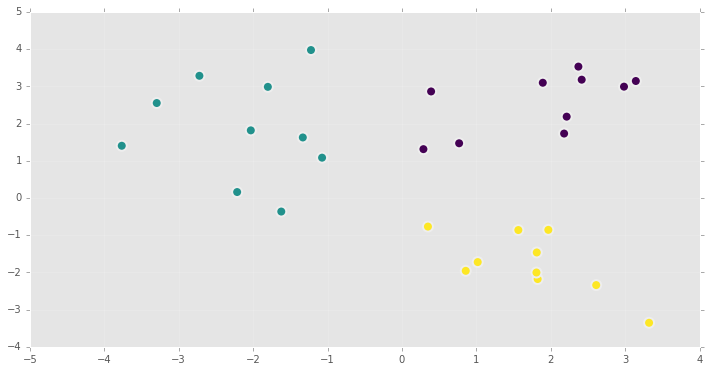

In [14]:
X = np.vstack([np.random.randn(10,2) + [2,2],
               np.random.randn(10,2) + [-2,2],
               np.random.randn(10,2) + [2,-2]])
Y = np.repeat(np.eye(3), 10, 0)

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
matplotlib.style.use('ggplot')


plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)

In [15]:
m = LinearMulticlass(X, Y)
m

Name,values,prior,constriant
model.b,[ 0.63834543 -1.20815029 -1.82042359],None,(none)
model.W,[[-0.92923651 -1.69574692 1.05649427] [-0.68789544 -0.81365612 -0.73554506]],None,(none)


In [16]:
m.optimize()
m

compiling tensorflow function...
done
optimization terminated, setting model state


Name,values,prior,constriant
model.b,[ 0.26730288 -5.73999646 3.08246513],None,(none)
model.W,[[ 5.83909396 -13.55470198 6.14711886] [ 3.83778751 3.03005646 -9.10494059]],None,(none)


In [17]:
xx, yy = np.mgrid[-4:4:200j, -4:4:200j]
X_test = np.vstack([xx.flatten(), yy.flatten()]).T
f_test = np.dot(X_test, m.W.value) + m.b._array
p_test = np.exp(f_test)
p_test /= p_test.sum(1)[:,None]

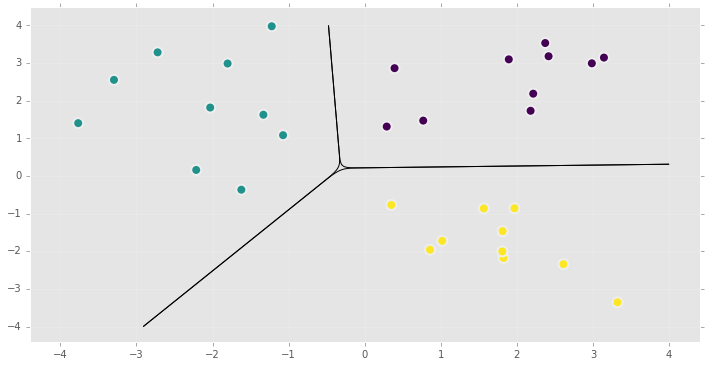

In [18]:
for i in range(3):
    plt.contour(xx, yy, p_test[:,i].reshape(200,200), [0.5], colors='k', linewidths=1)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)

That concludes the new model example and this notebook. You might want to convince yourself that the `LinearMulticlass` model and its parameters have all the functionality demonstrated above. You could also add some priors and run Hamiltonian Monte Carlo using `m.sample`. See the sparse_MCMC notebook for details of running the sampler.